In [13]:
import torch
import torch.utils.data as data
from matplotlib import pyplot as plt
import torchvision
from torch.autograd import Variable
from torchvision import transforms
from torch import nn
import os
import cv2
import numpy as np
from torch.nn import functional as F

In [28]:
root_dir = 'icons/png32/images/'
BATCH_SIZE = 64
num_epochs = 400

In [29]:
img_transform = transforms.Compose([
    transforms.ToTensor()])


In [30]:
class IconsDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.filenames = os.listdir(root_dir)
        
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = os.path.join(self.root_dir, self.filenames[idx])
        image = cv2.imread(filename)
        
        if self.transform:
            image = self.transform(image)

        return image

In [31]:
dataset = IconsDataset(root_dir, transform=img_transform)

In [32]:
loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)

In [67]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )
        self.fc_mu = nn.Linear(768,  300)
        self.fc_logvar = nn.Linear(768,  300)
        self.fc_unvectorize = nn.Linear(300, 768)
        
    
    def encode(self, x):
        vector = self.encoder(x)
        vector = vector.view(-1, 768)
        return self.fc_mu(vector), self.fc_logvar(vector)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h3 = F.relu(self.fc_unvectorize(z))
        h3 = h3.view(-1, 48, 4, 4)
        return self.decoder(h3)
        
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [68]:
criterion = nn.MSELoss()
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [69]:
model = Autoencoder().cuda()
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3)

In [70]:
from tqdm import tqdm
losses = []
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    for data in loader:
        img = data
        img = Variable(img).cuda()
        img = img.view(-1, 3, 32, 32)
        # ===================forward=====================
        recon_batch, mu, logvar = model(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        total_loss += loss.item()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    losses.append(total_loss)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, total_loss))



  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 1/400 [00:02<17:27,  2.62s/it]

epoch [1/400], loss:12607052.3086




  0%|          | 2/400 [00:04<15:18,  2.31s/it]

epoch [2/400], loss:10863760.0137




  1%|          | 3/400 [00:05<14:15,  2.15s/it]

epoch [3/400], loss:10230964.2266




  1%|          | 4/400 [00:07<13:00,  1.97s/it]

epoch [4/400], loss:9738628.9375




  1%|▏         | 5/400 [00:09<12:10,  1.85s/it]

epoch [5/400], loss:9380375.3945




  2%|▏         | 6/400 [00:10<11:33,  1.76s/it]

epoch [6/400], loss:9093853.1484




  2%|▏         | 7/400 [00:12<11:07,  1.70s/it]

epoch [7/400], loss:8883969.3105




  2%|▏         | 8/400 [00:13<11:11,  1.71s/it]

epoch [8/400], loss:8701318.7520




  2%|▏         | 9/400 [00:15<10:50,  1.66s/it]

epoch [9/400], loss:8544463.2305




  2%|▎         | 10/400 [00:17<10:39,  1.64s/it]

epoch [10/400], loss:8411498.2480




  3%|▎         | 11/400 [00:18<10:31,  1.62s/it]

epoch [11/400], loss:8296649.1836




  3%|▎         | 12/400 [00:20<10:52,  1.68s/it]

epoch [12/400], loss:8174305.6934




  3%|▎         | 13/400 [00:22<10:33,  1.64s/it]

epoch [13/400], loss:8085753.9766




  4%|▎         | 14/400 [00:23<10:46,  1.67s/it]

epoch [14/400], loss:7993945.2305




  4%|▍         | 15/400 [00:25<10:33,  1.65s/it]

epoch [15/400], loss:7911940.7168




  4%|▍         | 16/400 [00:26<10:23,  1.62s/it]

epoch [16/400], loss:7847788.5488




  4%|▍         | 17/400 [00:28<10:26,  1.63s/it]

epoch [17/400], loss:7772783.9453




  4%|▍         | 18/400 [00:30<10:12,  1.60s/it]

epoch [18/400], loss:7708213.3555




  5%|▍         | 19/400 [00:31<10:04,  1.59s/it]

epoch [19/400], loss:7652618.9785




  5%|▌         | 20/400 [00:33<10:14,  1.62s/it]

epoch [20/400], loss:7595799.7422




  5%|▌         | 21/400 [00:34<10:04,  1.59s/it]

epoch [21/400], loss:7542563.2695




  6%|▌         | 22/400 [00:36<09:58,  1.58s/it]

epoch [22/400], loss:7491598.7422




  6%|▌         | 23/400 [00:38<10:07,  1.61s/it]

epoch [23/400], loss:7451683.4473




  6%|▌         | 24/400 [00:39<10:00,  1.60s/it]

epoch [24/400], loss:7405802.1211




  6%|▋         | 25/400 [00:41<09:55,  1.59s/it]

epoch [25/400], loss:7360349.5254




  6%|▋         | 26/400 [00:42<10:03,  1.61s/it]

epoch [26/400], loss:7320625.2852




  7%|▋         | 27/400 [00:44<10:34,  1.70s/it]

epoch [27/400], loss:7286644.7773




  7%|▋         | 28/400 [00:46<10:19,  1.66s/it]

epoch [28/400], loss:7249107.9727




  7%|▋         | 29/400 [00:48<10:23,  1.68s/it]

epoch [29/400], loss:7220720.9688




  8%|▊         | 30/400 [00:49<10:27,  1.70s/it]

epoch [30/400], loss:7186158.8633




  8%|▊         | 31/400 [00:51<10:06,  1.64s/it]

epoch [31/400], loss:7158803.9551




  8%|▊         | 32/400 [00:52<09:53,  1.61s/it]

epoch [32/400], loss:7132430.2559




  8%|▊         | 33/400 [00:54<09:46,  1.60s/it]

epoch [33/400], loss:7109210.6230




  8%|▊         | 34/400 [00:56<09:40,  1.59s/it]

epoch [34/400], loss:7084197.4395




  9%|▉         | 35/400 [00:57<09:40,  1.59s/it]

epoch [35/400], loss:7063341.8398




  9%|▉         | 36/400 [00:59<09:35,  1.58s/it]

epoch [36/400], loss:7039589.4551




  9%|▉         | 37/400 [01:01<10:14,  1.69s/it]

epoch [37/400], loss:7023831.3848




 10%|▉         | 38/400 [01:02<10:13,  1.69s/it]

epoch [38/400], loss:6998748.1523




 10%|▉         | 39/400 [01:04<09:52,  1.64s/it]

epoch [39/400], loss:6983867.6016




 10%|█         | 40/400 [01:05<09:42,  1.62s/it]

epoch [40/400], loss:6966734.9355




 10%|█         | 41/400 [01:07<09:32,  1.59s/it]

epoch [41/400], loss:6951058.6758




 10%|█         | 42/400 [01:09<09:47,  1.64s/it]

epoch [42/400], loss:6935251.2520




 11%|█         | 43/400 [01:11<09:58,  1.68s/it]

epoch [43/400], loss:6920664.3105




 11%|█         | 44/400 [01:12<09:47,  1.65s/it]

epoch [44/400], loss:6909272.4961




 11%|█▏        | 45/400 [01:14<09:44,  1.65s/it]

epoch [45/400], loss:6896758.6973




 12%|█▏        | 46/400 [01:15<09:31,  1.61s/it]

epoch [46/400], loss:6881083.9258




 12%|█▏        | 47/400 [01:17<09:16,  1.58s/it]

epoch [47/400], loss:6868629.9492




 12%|█▏        | 48/400 [01:18<09:17,  1.58s/it]

epoch [48/400], loss:6852397.6680




 12%|█▏        | 49/400 [01:20<09:18,  1.59s/it]

epoch [49/400], loss:6845540.6016




 12%|█▎        | 50/400 [01:22<09:12,  1.58s/it]

epoch [50/400], loss:6840213.3750




 13%|█▎        | 51/400 [01:23<09:08,  1.57s/it]

epoch [51/400], loss:6830503.8945




 13%|█▎        | 52/400 [01:25<09:55,  1.71s/it]

epoch [52/400], loss:6815572.4727




 13%|█▎        | 53/400 [01:27<09:55,  1.72s/it]

epoch [53/400], loss:6803927.6602




 14%|█▎        | 54/400 [01:28<09:36,  1.67s/it]

epoch [54/400], loss:6797235.8457




 14%|█▍        | 55/400 [01:30<09:25,  1.64s/it]

epoch [55/400], loss:6785707.4844




 14%|█▍        | 56/400 [01:32<09:29,  1.65s/it]

epoch [56/400], loss:6779500.9629




 14%|█▍        | 57/400 [01:34<10:28,  1.83s/it]

epoch [57/400], loss:6771244.6914




 14%|█▍        | 58/400 [01:36<11:06,  1.95s/it]

epoch [58/400], loss:6765544.9023




 15%|█▍        | 59/400 [01:38<10:41,  1.88s/it]

epoch [59/400], loss:6756674.4863




 15%|█▌        | 60/400 [01:39<10:04,  1.78s/it]

epoch [60/400], loss:6743382.5859




 15%|█▌        | 61/400 [01:41<09:42,  1.72s/it]

epoch [61/400], loss:6736593.8008




 16%|█▌        | 62/400 [01:43<09:27,  1.68s/it]

epoch [62/400], loss:6734544.4785




 16%|█▌        | 63/400 [01:44<09:13,  1.64s/it]

epoch [63/400], loss:6731668.4531




 16%|█▌        | 64/400 [01:46<09:21,  1.67s/it]

epoch [64/400], loss:6721908.6465




 16%|█▋        | 65/400 [01:48<10:30,  1.88s/it]

epoch [65/400], loss:6714607.8008




 16%|█▋        | 66/400 [01:50<10:20,  1.86s/it]

epoch [66/400], loss:6711227.9414




 17%|█▋        | 67/400 [01:52<09:49,  1.77s/it]

epoch [67/400], loss:6701402.2754




 17%|█▋        | 68/400 [01:53<09:29,  1.71s/it]

epoch [68/400], loss:6693065.3887




 17%|█▋        | 69/400 [01:55<10:08,  1.84s/it]

epoch [69/400], loss:6695491.4375




 18%|█▊        | 70/400 [01:58<10:52,  1.98s/it]

epoch [70/400], loss:6689843.1816




 18%|█▊        | 71/400 [01:59<10:05,  1.84s/it]

epoch [71/400], loss:6679961.7227




 18%|█▊        | 72/400 [02:01<09:32,  1.74s/it]

epoch [72/400], loss:6679384.7441




 18%|█▊        | 73/400 [02:02<09:11,  1.69s/it]

epoch [73/400], loss:6668836.4121




 18%|█▊        | 74/400 [02:04<09:20,  1.72s/it]

epoch [74/400], loss:6664209.6035




 19%|█▉        | 75/400 [02:06<09:54,  1.83s/it]

epoch [75/400], loss:6665300.5684




 19%|█▉        | 76/400 [02:08<09:29,  1.76s/it]

epoch [76/400], loss:6658334.4473




 19%|█▉        | 77/400 [02:09<09:07,  1.69s/it]

epoch [77/400], loss:6657544.7461




 20%|█▉        | 78/400 [02:11<08:51,  1.65s/it]

epoch [78/400], loss:6647531.4883




 20%|█▉        | 79/400 [02:12<08:42,  1.63s/it]

epoch [79/400], loss:6642860.1738




 20%|██        | 80/400 [02:14<09:13,  1.73s/it]

epoch [80/400], loss:6641246.7402




 20%|██        | 81/400 [02:16<09:20,  1.76s/it]

epoch [81/400], loss:6634558.8613




 20%|██        | 82/400 [02:18<09:00,  1.70s/it]

epoch [82/400], loss:6632400.6582




 21%|██        | 83/400 [02:19<08:42,  1.65s/it]

epoch [83/400], loss:6627463.7871




 21%|██        | 84/400 [02:21<08:57,  1.70s/it]

epoch [84/400], loss:6625764.7188




 21%|██▏       | 85/400 [02:23<08:58,  1.71s/it]

epoch [85/400], loss:6622053.5410




 22%|██▏       | 86/400 [02:24<08:50,  1.69s/it]

epoch [86/400], loss:6615916.2383




 22%|██▏       | 87/400 [02:27<09:55,  1.90s/it]

epoch [87/400], loss:6612957.3926




 22%|██▏       | 88/400 [02:29<10:42,  2.06s/it]

epoch [88/400], loss:6610061.1328




 22%|██▏       | 89/400 [02:31<10:19,  1.99s/it]

epoch [89/400], loss:6603119.4492




 22%|██▎       | 90/400 [02:33<10:01,  1.94s/it]

epoch [90/400], loss:6604666.3828




 23%|██▎       | 91/400 [02:34<09:26,  1.83s/it]

epoch [91/400], loss:6600173.6445




 23%|██▎       | 92/400 [02:36<09:25,  1.83s/it]

epoch [92/400], loss:6594788.4297




 23%|██▎       | 93/400 [02:38<08:59,  1.76s/it]

epoch [93/400], loss:6595536.0586




 24%|██▎       | 94/400 [02:39<08:39,  1.70s/it]

epoch [94/400], loss:6588699.2285




 24%|██▍       | 95/400 [02:41<08:45,  1.72s/it]

epoch [95/400], loss:6585859.0293




 24%|██▍       | 96/400 [02:43<08:38,  1.71s/it]

epoch [96/400], loss:6583637.8691




 24%|██▍       | 97/400 [02:45<08:47,  1.74s/it]

epoch [97/400], loss:6578679.0254




 24%|██▍       | 98/400 [02:47<08:58,  1.78s/it]

epoch [98/400], loss:6580667.3594




 25%|██▍       | 99/400 [02:49<09:29,  1.89s/it]

epoch [99/400], loss:6574948.1699




 25%|██▌       | 100/400 [02:50<09:08,  1.83s/it]

epoch [100/400], loss:6568915.7188




 25%|██▌       | 101/400 [02:52<09:03,  1.82s/it]

epoch [101/400], loss:6566199.8809




 26%|██▌       | 102/400 [02:54<08:51,  1.78s/it]

epoch [102/400], loss:6568041.2363




 26%|██▌       | 103/400 [02:56<08:36,  1.74s/it]

epoch [103/400], loss:6563497.2344




 26%|██▌       | 104/400 [02:57<08:31,  1.73s/it]

epoch [104/400], loss:6563721.7695




 26%|██▋       | 105/400 [02:59<08:34,  1.74s/it]

epoch [105/400], loss:6560808.2012




 26%|██▋       | 106/400 [03:01<08:32,  1.74s/it]

epoch [106/400], loss:6556653.9414




 27%|██▋       | 107/400 [03:02<08:22,  1.72s/it]

epoch [107/400], loss:6555694.9648




 27%|██▋       | 108/400 [03:04<08:16,  1.70s/it]

epoch [108/400], loss:6549400.8320




 27%|██▋       | 109/400 [03:06<08:24,  1.73s/it]

epoch [109/400], loss:6552074.2988




 28%|██▊       | 110/400 [03:08<08:23,  1.74s/it]

epoch [110/400], loss:6549395.0176




 28%|██▊       | 111/400 [03:09<08:08,  1.69s/it]

epoch [111/400], loss:6548004.3125




 28%|██▊       | 112/400 [03:11<08:04,  1.68s/it]

epoch [112/400], loss:6536615.8848




 28%|██▊       | 113/400 [03:13<08:01,  1.68s/it]

epoch [113/400], loss:6538461.4102




 28%|██▊       | 114/400 [03:14<07:56,  1.67s/it]

epoch [114/400], loss:6536480.9941




 29%|██▉       | 115/400 [03:16<07:50,  1.65s/it]

epoch [115/400], loss:6532450.1543




 29%|██▉       | 116/400 [03:18<08:03,  1.70s/it]

epoch [116/400], loss:6534669.4766




 29%|██▉       | 117/400 [03:19<08:10,  1.73s/it]

epoch [117/400], loss:6532156.6602




 30%|██▉       | 118/400 [03:21<08:09,  1.74s/it]

epoch [118/400], loss:6527170.6953




 30%|██▉       | 119/400 [03:23<08:08,  1.74s/it]

epoch [119/400], loss:6526027.6113




 30%|███       | 120/400 [03:25<08:00,  1.72s/it]

epoch [120/400], loss:6520663.0586




 30%|███       | 121/400 [03:26<07:48,  1.68s/it]

epoch [121/400], loss:6517303.2949




 30%|███       | 122/400 [03:28<07:59,  1.73s/it]

epoch [122/400], loss:6523764.6328




 31%|███       | 123/400 [03:30<07:53,  1.71s/it]

epoch [123/400], loss:6515910.4961




 31%|███       | 124/400 [03:31<07:42,  1.68s/it]

epoch [124/400], loss:6515222.1406




 31%|███▏      | 125/400 [03:33<07:41,  1.68s/it]

epoch [125/400], loss:6512588.6582




 32%|███▏      | 126/400 [03:35<07:47,  1.71s/it]

epoch [126/400], loss:6514743.2930




 32%|███▏      | 127/400 [03:36<07:33,  1.66s/it]

epoch [127/400], loss:6508091.1367




 32%|███▏      | 128/400 [03:38<07:21,  1.62s/it]

epoch [128/400], loss:6509959.4961




 32%|███▏      | 129/400 [03:39<07:14,  1.60s/it]

epoch [129/400], loss:6504256.1875




 32%|███▎      | 130/400 [03:41<07:27,  1.66s/it]

epoch [130/400], loss:6502670.2051




 33%|███▎      | 131/400 [03:43<07:43,  1.72s/it]

epoch [131/400], loss:6502509.6875




 33%|███▎      | 132/400 [03:45<08:31,  1.91s/it]

epoch [132/400], loss:6501945.8438




 33%|███▎      | 133/400 [03:48<09:00,  2.03s/it]

epoch [133/400], loss:6498108.1953




 34%|███▎      | 134/400 [03:50<08:56,  2.02s/it]

epoch [134/400], loss:6496655.0391




 34%|███▍      | 135/400 [03:51<08:12,  1.86s/it]

epoch [135/400], loss:6492200.1641




 34%|███▍      | 136/400 [03:53<08:01,  1.82s/it]

epoch [136/400], loss:6493359.2812




 34%|███▍      | 137/400 [03:55<08:12,  1.87s/it]

epoch [137/400], loss:6489686.6934




 34%|███▍      | 138/400 [03:57<07:52,  1.80s/it]

epoch [138/400], loss:6487892.5605




 35%|███▍      | 139/400 [03:58<07:29,  1.72s/it]

epoch [139/400], loss:6492364.1914




 35%|███▌      | 140/400 [04:00<07:12,  1.66s/it]

epoch [140/400], loss:6488748.5918




 35%|███▌      | 141/400 [04:01<06:57,  1.61s/it]

epoch [141/400], loss:6480366.0684




 36%|███▌      | 142/400 [04:03<06:47,  1.58s/it]

epoch [142/400], loss:6484647.5898




 36%|███▌      | 143/400 [04:04<06:43,  1.57s/it]

epoch [143/400], loss:6485705.9766




 36%|███▌      | 144/400 [04:06<06:44,  1.58s/it]

epoch [144/400], loss:6481227.6797




 36%|███▋      | 145/400 [04:08<07:06,  1.67s/it]

epoch [145/400], loss:6477223.8320




 36%|███▋      | 146/400 [04:10<07:55,  1.87s/it]

epoch [146/400], loss:6475981.8242




 37%|███▋      | 147/400 [04:11<07:25,  1.76s/it]

epoch [147/400], loss:6473663.1445




 37%|███▋      | 148/400 [04:13<07:03,  1.68s/it]

epoch [148/400], loss:6472764.9180




 37%|███▋      | 149/400 [04:14<06:49,  1.63s/it]

epoch [149/400], loss:6473468.5117




 38%|███▊      | 150/400 [04:16<06:36,  1.59s/it]

epoch [150/400], loss:6470395.9883




 38%|███▊      | 151/400 [04:18<06:56,  1.67s/it]

epoch [151/400], loss:6467952.0957




 38%|███▊      | 152/400 [04:20<06:57,  1.68s/it]

epoch [152/400], loss:6469526.5977




 38%|███▊      | 153/400 [04:21<07:11,  1.75s/it]

epoch [153/400], loss:6464206.9473




 38%|███▊      | 154/400 [04:25<09:22,  2.28s/it]

epoch [154/400], loss:6464181.1230




 39%|███▉      | 155/400 [04:27<09:13,  2.26s/it]

epoch [155/400], loss:6462717.3398




 39%|███▉      | 156/400 [04:29<08:20,  2.05s/it]

epoch [156/400], loss:6460938.0312




 39%|███▉      | 157/400 [04:30<07:42,  1.90s/it]

epoch [157/400], loss:6462870.4473




 40%|███▉      | 158/400 [04:32<07:21,  1.82s/it]

epoch [158/400], loss:6461652.4512


KeyboardInterrupt: 

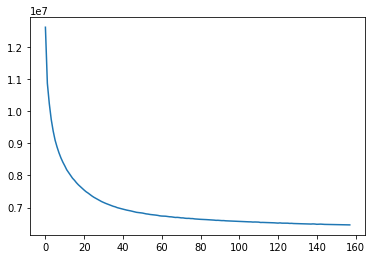

In [71]:
plt.plot(losses)

In [72]:
convert = lambda x:np.transpose(x, (1, 2, 0))

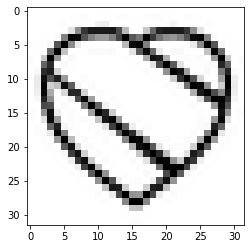

In [73]:
test_batch = next(iter(loader))
plt.imshow(convert(test_batch[1]))

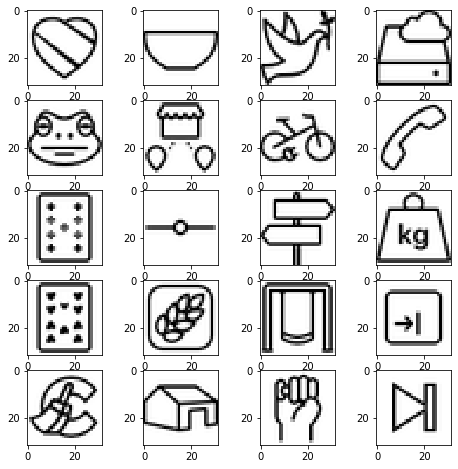

In [74]:
var = Variable(test_batch).cuda()
test_batch = test_batch.view(-1, 3, 32, 32)
res = model(var)

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(convert(test_batch[i]))
plt.show()

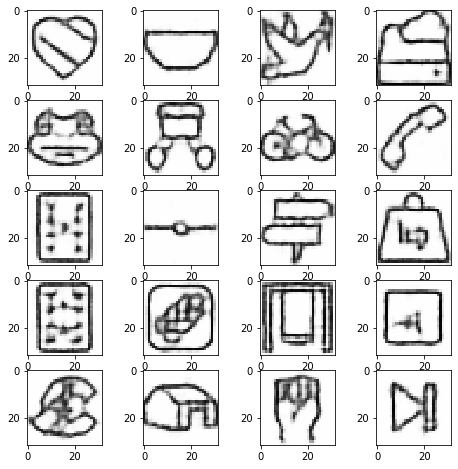

In [75]:
#.cpu().detach().numpy()
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(convert(res[0][i].cpu().detach().numpy()))
plt.show()

In [1]:
with torch.no_grad():
    sample = torch.randn(64, 300).cuda()
    sample = model.decode(sample).cpu()
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = np.random.randint(10, size=(h,w))
        fig.add_subplot(rows, columns, i)
        plt.imshow(convert(sample[i]))
    plt.show()
    

NameError: name 'torch' is not defined